# Treinamento de Rede Neural com SNR aleatório

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from libs.commpy_mod import SISOFlatChannel

from files_01_detection.const_mod import generate_symbols, Model
from files_01_detection.const_analyzer import plot_decision_boundary, theoretical_error, ser, plot_confusion_matrix, plot_symbols
 
%matplotlib inline

2023-03-22 15:46:34.163032: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 15:46:35.310256: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 15:46:35.310316: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-22 15:46:35.487647: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-22 15:46:37.742882: W tensorflow/stream_executor/platform/de

In [2]:
total_num_symbols  = 1000000    # Number of transmitted symbols to be used for training and test
train_fraction = 0.7 # Fraction of whole data to be used for training (the remaining is for testing)
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy
Mod = 'QAM'
channel_type = 'rayleigh' # 'awgn' or 'crazy'
M            = 16      # PSK modulation

In [3]:
def conjunto(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB, symb=False, scaler=None):

    symbs, indices, channel_output = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, [SNR_dB[0]])
    x = np.stack([np.real(channel_output[0][:]),
                    np.imag(channel_output[0][:])], axis=1)

    if scaler is not None:
        x = scaler(np.concatenate((x, np.array([channel_output[1]]).T), axis=1))
    else:
        x = np.concatenate((x, np.array([channel_output[1]]).T), axis=1)
    
    x = x.reshape(1,-1,3)
    
    for i in range(1, len(SNR_dB)):
        a, b, c = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB[i])
        
        d = np.stack([np.real(c[0][:]), np.imag(c[0][:])], axis=1)
        
        if scaler is not None:
            d = scaler(np.concatenate((d, np.array([c[1]]).T), axis=1))
        else:
            d = np.concatenate((d, np.array([c[1]]).T), axis=1)
        
        symbs = np.vstack((symbs, a))
        indices = np.vstack((indices, b))
        channel_output = np.vstack((channel_output, c))
        x = np.vstack((x, d.reshape(1,-1,3)))
    
    y = np.float_(indices)
        
    if symb:
        return x, y, symbs
    else:
        return x, y

In [4]:
def Train_Data(Mod, total_num_symbols, M, channel_type, Es, code_rate, min, max):

    symbs, indices, channel_output = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, [min, max])
    x = np.stack([np.real(channel_output[0][:]),
                    np.imag(channel_output[0][:])], axis=1)
    x = np.concatenate((x, np.array([np.real(channel_output[1])]).T), axis=1)
    
    y = np.float_(indices[0])
    
    return x, y, symbs
"""
    indices = np.array([])
    symbs = np.array([])
    channel_output = np.array([])
    alpha = np.array([])
    for i in range(total_num_symbols):
        a, b, c = Model(Mod, 1, M, channel_type, Es, code_rate, np.random.randint(min, max))
        symbs = np.append(symbs, a)
        indices = np.append(indices, b)
        channel_output = np.append(channel_output, c[0])
        alpha = np.append(alpha, c[1])
        
    x = np.stack([np.real(channel_output[:]),
                        np.imag(channel_output[:])], axis=1)
    x = np.concatenate((x, np.array([alpha]).T), axis=1)
    
    y = np.float_(indices)
"""

'\n    indices = np.array([])\n    symbs = np.array([])\n    channel_output = np.array([])\n    alpha = np.array([])\n    for i in range(total_num_symbols):\n        a, b, c = Model(Mod, 1, M, channel_type, Es, code_rate, np.random.randint(min, max))\n        symbs = np.append(symbs, a)\n        indices = np.append(indices, b)\n        channel_output = np.append(channel_output, c[0])\n        alpha = np.append(alpha, c[1])\n        \n    x = np.stack([np.real(channel_output[:]),\n                        np.imag(channel_output[:])], axis=1)\n    x = np.concatenate((x, np.array([alpha]).T), axis=1)\n    \n    y = np.float_(indices)\n'

In [24]:
x_out, y_out, symbs = Train_Data(Mod, total_num_symbols, M, channel_type, Es, code_rate, 5, 30)

In [5]:
x_out = np.fromfile('Random_Data/SNR_8-12/Rayleigh/16-QAM/x_rand.dat', dtype=np.dtype('float64')).reshape((-1,3))
y_out = np.fromfile('Random_Data/SNR_8-12/Rayleigh/16-QAM/y_rand.dat', dtype=np.dtype('float64'))
symbs = np.fromfile('Random_Data/SNR_8-12/Rayleigh/16-QAM/symb.dat', dtype=np.dtype('complex128')).reshape((1,-1))

In [6]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
y_train = y_out[:train_size]
X_train = x_out[:train_size]

# Test
y_test = y_out[train_size:]
X_test = x_out[train_size:]

scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


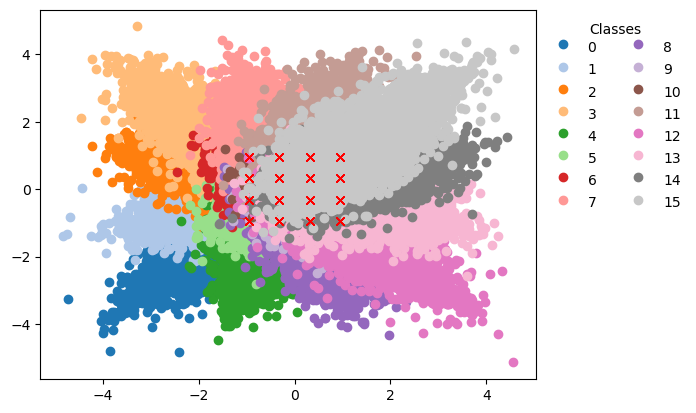

In [7]:
plot_symbols(X_train, y_train, M, symbs)

## Criação e treinamento da Rede Neural

In [ ]:
n_inputs = np.shape(X_train)[1]

In [31]:
n_redes = 3
n_hidden = [[150, 80, 50],
            [300, 180, 90, 40],
            [500, 380, 240, 135, 80]]

n_outputs = M
learning_rate = [0.01, 0.01, 0.001]
n_epochs = [10, 10, 10]
batch_size = [800, 1600, 2400]
momentum = [0.7, 0.8, 0.9]

In [7]:
y_train = tf.reshape(tf.convert_to_tensor(y_train), [-1, 1])
y_test = tf.reshape(tf.convert_to_tensor(y_test), [-1, 1])
X_test = tf.convert_to_tensor(X_test)
X_train = tf.convert_to_tensor(X_train)

2023-03-22 15:51:00.661815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-22 15:51:00.662589: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-22 15:51:00.662679: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (keko-ubuntu): /proc/driver/nvidia/version does not exist
2023-03-22 15:51:00.669542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Usando API Keras

In [20]:
inputs = tf.keras.Input(shape=(n_inputs,))
output = []

for i in range(n_redes):
    x = inputs
    for j in range(len(n_hidden[i])):
        x = tf.keras.layers.Dense(n_hidden[i][j], activation="elu", kernel_initializer="glorot_normal")(x)
    output.append(tf.keras.layers.Dense(n_outputs, kernel_initializer="glorot_normal")(x))

In [32]:
model_QAM = []
for i in range(n_redes):
    model_QAM.append(tf.keras.Model(inputs=inputs, outputs=output[i]))

    model_QAM[i].compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=learning_rate[i], momentum=momentum[i], nesterov=True),
                 metrics=["accuracy"])

    history = model_QAM[i].fit(X_train, y_train, batch_size=batch_size[i], epochs=n_epochs[i], shuffle=True)

    tests_score = model_QAM[i].evaluate(X_test, y_test)
    print("\nTest loss:", tests_score[0])
    print("Test accuracy:", tests_score[1])
    print(f"Taxa de erro simbólica de {(1 - tests_score[1]):.2%}\n")

Epoch 1/10
875/875 [==============================] - 5s 5ms/step - loss: 1.0125 - accuracy: 0.6378
Epoch 2/10
875/875 [==============================] - 5s 5ms/step - loss: 1.0123 - accuracy: 0.6379
Epoch 3/10
875/875 [==============================] - 5s 5ms/step - loss: 1.0119 - accuracy: 0.6380
Epoch 4/10
875/875 [==============================] - 5s 5ms/step - loss: 1.0118 - accuracy: 0.6381
Epoch 5/10
875/875 [==============================] - 5s 6ms/step - loss: 1.0115 - accuracy: 0.6382
Epoch 6/10
875/875 [==============================] - 5s 6ms/step - loss: 1.0115 - accuracy: 0.6379
Epoch 7/10
875/875 [==============================] - 5s 5ms/step - loss: 1.0113 - accuracy: 0.6381
Epoch 8/10
875/875 [==============================] - 5s 6ms/step - loss: 1.0112 - accuracy: 0.6379
Epoch 9/10
875/875 [==============================] - 5s 5ms/step - loss: 1.0110 - accuracy: 0.6380
Epoch 10/10
9375/9375 [==============================] - 16s 2ms/step - loss: 1.0101 - accuracy: 0.6

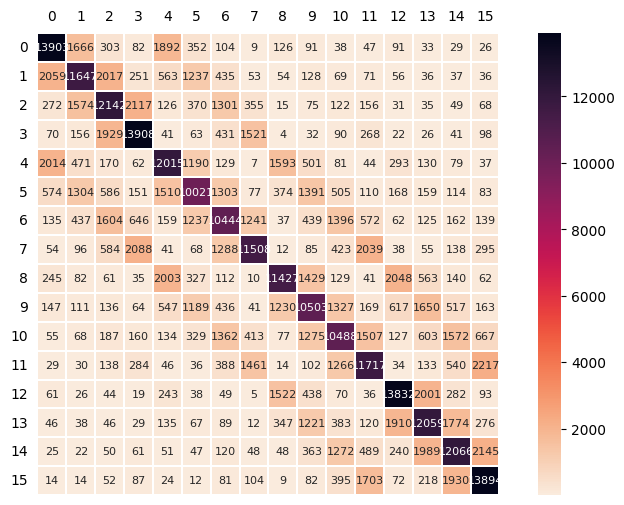

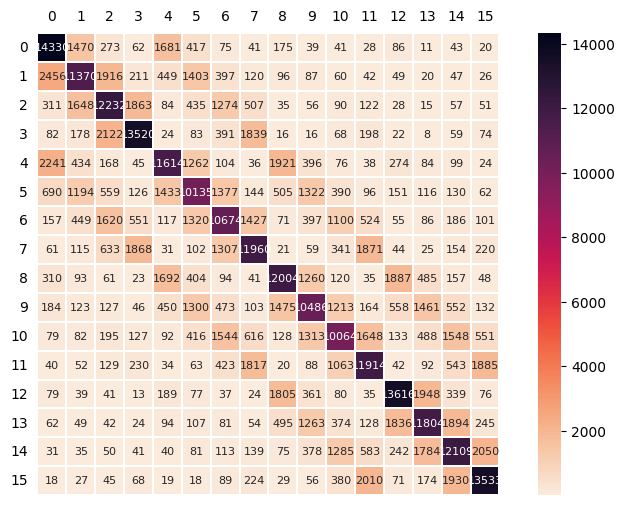

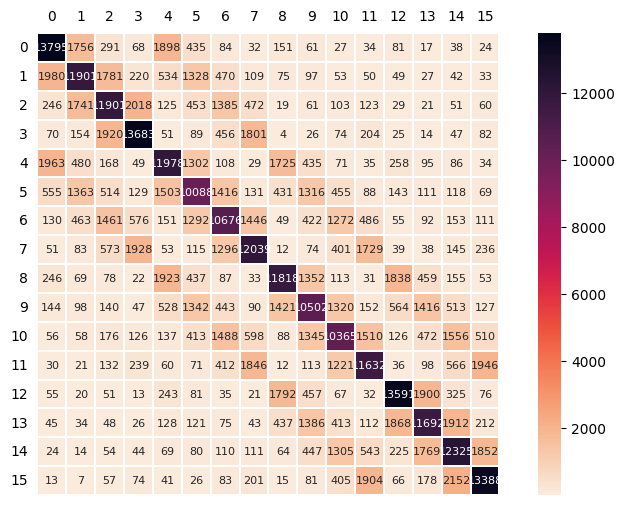

In [33]:
for i in range(n_redes):
    plot_confusion_matrix(model_QAM[i], X_test, y_test, M, nn=True)
#plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True)
#plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True, plot_training=False)

## Avaliação do modelo em diferentes faixas de relação sinal/ruído

### QAM | Rayleigh

In [34]:
Mod = "QAM"
channel_type = "rayleigh"
M = 16
init_scale = 2
interval = 18
passo = 1

In [35]:
Teo_SNRs = [theoretical_error(Mod, M, init_scale + i, channel_type) for i in range(0, interval, passo)]

In [36]:
amostras = [conjunto(Mod, int(200 / (Teo_SNRs[int(i / passo)] * np.log2(M))), M, channel_type, Es, code_rate, [init_scale + i], False, scaler.transform) for i in range(0, interval, passo)]

In [37]:
error_rate = ([[ser(model_QAM[j], tf.reshape(tf.convert_to_tensor(amostras[i][0]), [-1, 3]),
                              tf.reshape(tf.convert_to_tensor(amostras[i][1]), [-1, 1]), nn=True)
              for i in range(len(amostras))] for j in range(n_redes)]) / (tf.math.log(float(M))/tf.math.log(2.))

In [38]:
error_rate

<tf.Tensor: shape=(3, 18), dtype=float32, numpy=
array([[0.17180094, 0.16333333, 0.14522822, 0.14367816, 0.1368421 ,
        0.11825397, 0.11576705, 0.10364322, 0.08461539, 0.08460076,
        0.07003257, 0.05931034, 0.05005787, 0.0433526 , 0.03520286,
        0.02984344, 0.0231383 , 0.02277634],
       [0.17061612, 0.16333333, 0.14626557, 0.14367816, 0.1368421 ,
        0.11904762, 0.11860795, 0.10364322, 0.08681319, 0.0865019 ,
        0.06962541, 0.06034483, 0.05121528, 0.04455684, 0.03381066,
        0.02853881, 0.0231383 , 0.02299223],
       [0.17180094, 0.16444445, 0.14730291, 0.14272031, 0.13859649,
        0.11984127, 0.11647727, 0.10175879, 0.08681319, 0.08887833,
        0.07084691, 0.06068965, 0.05150463, 0.0433526 , 0.03420843,
        0.03000652, 0.02207447, 0.02223662]], dtype=float32)>

In [39]:
np.mean(error_rate - Teo_SNRs)

-0.023916574

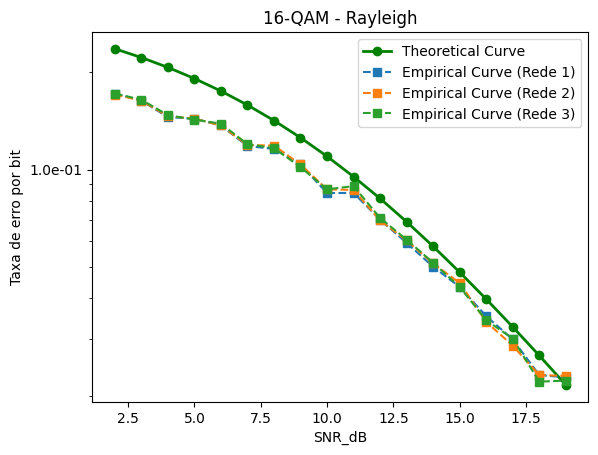

In [40]:
import matplotlib.ticker as tick

y1 = Teo_SNRs
x = range(init_scale, init_scale + interval, passo)

fig, ax = plt.subplots(1,1)

ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
[ax.plot(x, error_rate[i], 's--', label=f'Empirical Curve (Rede {i + 1})') for i in range(n_redes)]

ax.set_title('16-QAM - Rayleigh')
ax.set_xlabel('SNR_dB')
ax.set_ylabel('Taxa de erro por bit')

def y_fmt(x, y):
    return '{:2.1e}'.format(x)

ax.set_yscale("log")
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#plt.plot(x2, y2, 'rs--',  label='line 2')

plt.legend()
plt.show()